# Need to clone my REBOUND fork specifically, i.e., 

git clone https://github.com/dtamayo/rebound.git

- For resonant and TTV systems use commit 6fb912f615ca542b670ab591375191d1ed914672 (on master branch)
- For random and Naireen random systems use REBOUND commit 4a6c79ae14ffde27828dd9d1f8d8afeba94ef048 (on the spockrandomintegrations branch--currently HEAD)

The resonant and TTV (KOI-1576) systems use different REBOUND commits (a675e6f92cba32bae86f94739faec3b1b3098e81 for resonant). The problem is that this version doesn't have a __del__ function for the simulation archives and you get an error of too many open files when you run this. There was also a bug with keep_unsynchronized=1 and using MEGNO, so we now use the patch 06c95e2a69d319de3b077d92f2541cdcdf68a8fa. I test below that an integration that initializes MEGNO gives the same result as the original sim archives that don't. I then fixed something with collisions so the commit to use is 6fb912f615ca542b670ab591375191d1ed914672. Can see details in REBOUND repo pull requests.

The commit 4a6c79ae14ffde27828dd9d1f8d8afeba94ef048 on the spockrandomintegrations branch works for the random set of integrations. I had to branch from the old commit used to run the long integrations db3ae2cea8f3462463d3e0c5788a34625bb49a9c (actually it's not the exact one but close to it), and add the patches to calculate megno/lyap correctly with keep_unsynchronized=1 (which we need to match bit by bit). Had to update from 48feb327f90611a5569682578980b5604aa6102a to also keep pos/vel unsynchronized when using megno so that collisions are caught at the same time. In general I don't think  we want that in there (in our training dataset we are catching collisions with unsynchronized states, which is not correct, but statistically fine).
I also had to add jacobi_masses to sim.calculate_orbits in order for celmech to work correctly. This is the latest patch on top of the last, which was 361adacb48ff55ea8331adbf37a943e63ca02984.

The commit you load above will work for the corresponding set of archives loaded below. The others won't give identical results (or fail altogether). But the same testsim function can work on all which lets us always use the same function in generatedata/training_data_functions.py. 

When we ran the resonant integrations (with the new simarchive), we did with safe_mode = 0 so we don't repeat kepler half steps. This means the sim will be in an unsynchronized state (see simarchiverestart ipython_example) when we load any snapshot but the first one, so we have to synchronize before comparing output. 

We need to use sim.ri_whfast.keep_unsynchronized = 1 for reproducibility. A value of 1 means that even if you synchronize, you'll keep integrating from the unsynchronized state if you keep going. So when integrating through a list of times, we need to set this if we want to match the sim archives. 

# We keep the above (and this notebook) for our reference and that of anyone wanting to reproduce the exact chaotic trajectories in our long (1e9 orbit) integrations

The workarounds mentioned above were introduced so that the short integrations, which need to calculate the MEGNO, can match the long integrations. The issue is that the long integrations are run with ri_whfast.safe_mode=0, while the short integrations have to synchronize every timestep to calculate the MEGNO. The commits above therefore cache the unsynchronized states, and revert to them after calculating the MEGNO, yielding the same safe_mode = 0 trajectory. However, we found that calculating the MEGNO after each timestep using an inconsistent trajectory that always reverts to unsynchronized state causes a scale-dependence to the MEGNO--it's fine for natural units (G=4pi^2, distance = innermost semimajor axis, time =innermost orbital period), but for long period orbits MEGNO settles to > 2 instead of 2 for regular orbits.

So we decided to drop the requirement that we match the exact chaotic trajectory of the long integrations in the short integrations. This is also physically reasonable since both trajectories are equally valid draws from the distribution of chaotic trajectories associated with the initial condition. This also lets us use different timesteps (we now default to 0.05 smallest pericenter passage time) for both SPOCK and nbody. We checked that using these different chaotic realizations to predict the long term integrations had a negligible effect compared to using the exact same trajectories.

In summary, you can easily get the same trajectories as the long-term ones if you use safe_mode=0 (but can't calculate MEGNO), you can use the above commits to calculate MEGNO and use the same trajectories above if you use natural units (but there's a funny scale dependence otherwise), or you can use different chaotic realizations and it doesn't make a statistically significant difference.

# When comparing reruns to label instability times, note that instability sim.t has been divided by P0 = sim.particles[1].P at t=0

In [1]:
from platform import python_version
print(python_version() )
import rebound
print(rebound.__version__)

3.8.16
3.8.3


/mnt/ssd/home/yba/rebound/rebound/simulation.py:766: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if func is "merge":
/mnt/ssd/home/yba/rebound/rebound/simulation.py:769: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif func is "hardsphere":
/mnt/ssd/home/yba/rebound/rebound/units.py:96: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(newunits) is not 3:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import rebound
%matplotlib inline
#change it to my dictionary
datafolder = '/home/yba/spock/data/'
Nout = 1729


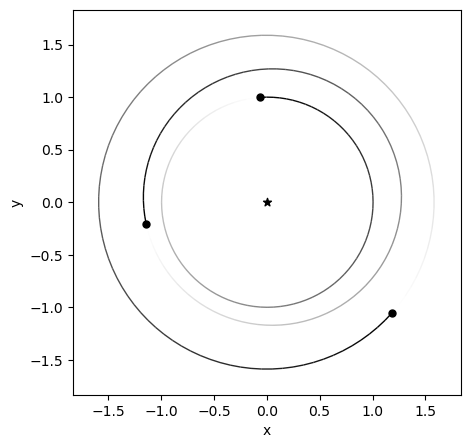

In [7]:
# read one initial condition of specific planet
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000000.bin')# read the file
sim2 = sa[0] # read the initial condition
fig = rebound.OrbitPlot(sim2) #plot it first


In [16]:
# read the mass of four planet
m0 = sim.particles[0].m
m1 = sim.particles[1].m
m2 = sim.particles[2].m
m3 = sim.particles[3].m

vx0 = sim.particles[0].vx
vx1 = sim.particles[1].vx
vx2 = sim.particles[2].vx
vx3 = sim.particles[3].vx

vy0 = sim.particles[0].vy
vy1 = sim.particles[1].vy
vy2 = sim.particles[2].vy
vy3 = sim.particles[3].vy

vz0 = sim.particles[0].vz
vz1 = sim.particles[1].vz
vz2 = sim.particles[2].vz
vz3 = sim.particles[3].vz

x0 = sim.particles[0].x
x1 = sim.particles[1].x
x2 = sim.particles[2].x
x3 = sim.particles[3].x

y0 = sim.particles[0].y
y1 = sim.particles[1].y
y2 = sim.particles[2].y
y3 = sim.particles[3].y

z0 = sim.particles[0].z
z1 = sim.particles[1].z
z2 = sim.particles[2].z
z3 = sim.particles[3].z

n = np.array([m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3])
print(n)

[ 1.00000000e+00  2.15130955e-05 -2.83134950e-05 -3.59702797e-07
  1.84889790e-04  1.18365239e-04 -2.10835927e-06  3.41401602e-05
 -6.58395691e-02  9.97590610e-01 -1.20070677e-03 -6.26836429e+00
 -4.45311905e-01  5.59526195e-02  1.87872498e-05 -1.14094577e+00
 -2.03694227e-01  1.67610664e-02  1.22970372e+00 -5.85542851e+00
 -1.77819457e-02  1.82689986e-06  1.18775592e+00 -1.04962178e+00
  4.69652335e-02  3.28995608e+00  3.74688215e+00  2.91314126e-01]


In [9]:
# write all initial condition to csv file
with open('data.csv', 'w') as f:
    for i in range(25000):
        fileName = f"sa{i:07d}.bin"
        # find the corresponding file
        sa = rebound.SimulationArchive(datafolder+"random/simulation_archives/runs/"+fileName)# read the file
        sim = sa[0] # read the initial condition
        m0 = sim.particles[0].m
        m1 = sim.particles[1].m
        m2 = sim.particles[2].m
        m3 = sim.particles[3].m

        vx0 = sim.particles[0].vx
        vx1 = sim.particles[1].vx
        vx2 = sim.particles[2].vx
        vx3 = sim.particles[3].vx

        vy0 = sim.particles[0].vy
        vy1 = sim.particles[1].vy
        vy2 = sim.particles[2].vy
        vy3 = sim.particles[3].vy

        vz0 = sim.particles[0].vz
        vz1 = sim.particles[1].vz
        vz2 = sim.particles[2].vz
        vz3 = sim.particles[3].vz

        x0 = sim.particles[0].x
        x1 = sim.particles[1].x
        x2 = sim.particles[2].x
        x3 = sim.particles[3].x

        y0 = sim.particles[0].y
        y1 = sim.particles[1].y
        y2 = sim.particles[2].y
        y3 = sim.particles[3].y

        z0 = sim.particles[0].z
        z1 = sim.particles[1].z
        z2 = sim.particles[2].z
        z3 = sim.particles[3].z

        data = [m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3]  # Create an example row of data
        np.savetxt(f, [data], delimiter=',',fmt='%0.16f')  # Write the row to the file


[ 1.00000000e+00  2.15130955e-05 -2.83134950e-05 -3.59702797e-07
  1.84889790e-04  1.18365239e-04 -2.10835927e-06  3.41401602e-05
 -6.58395691e-02  9.97590610e-01 -1.20070677e-03 -6.26836429e+00
 -4.45311905e-01  5.59526195e-02  1.87872498e-05 -1.14094577e+00
 -2.03694227e-01  1.67610664e-02  1.22970372e+00 -5.85542851e+00
 -1.77819457e-02  1.82689986e-06  1.18775592e+00 -1.04962178e+00
  4.69652335e-02  3.28995608e+00  3.74688215e+00  2.91314126e-01]


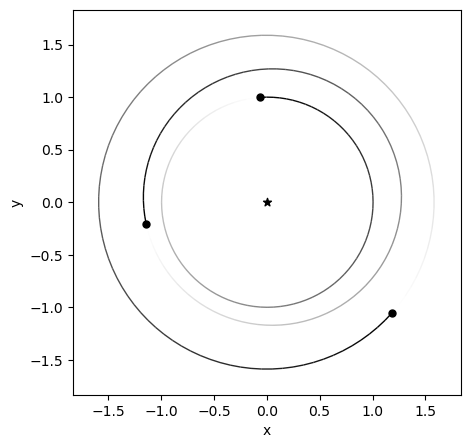

In [6]:
# import numpy as np
# import rebound

# Read the CSV file, contain all data
all_data = np.loadtxt('data.csv', delimiter=',',dtype=np.float64)
#choose a specific row
data = all_data[0]


print(data)
#plot
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])
fig1 = rebound.OrbitPlot(sim)


In [8]:
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Apr 13 2023 15:23:52
Number of particles: 	4
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=2.15130954841e-05 y=-2.83134950296e-05 z=-3.597027971e-07 vx=0.0001848897897435 vy=0.0001183652392055 vz=-2.1083592745e-06>
<rebound.Particle object, m=3.41401601921e-05 x=-0.0658395691020751 y=0.9975906097309251 z=-0.0012007067725723 vx=-6.2683642902381935 vy=-0.4453119046693618 vz=0.0559526195024052>
<rebound.Particle object, m=1.87872497534e-05 x=-1.1409457714716873 y=-0.2036942270946636 z=0.0167610663709493 vx=1.2297037225646998 vy=-5.855428514295627 vz=-0.0177819457007752>
<rebound.Particle object, m=1.8268998599e-06 x=1.187755915572346 y=-1.0496217757080577 z=0.046965233541598 vx=3.289956084023555 vy=3.7468821454248484 vz=0.2913141262963352>
---------------------------------


In [9]:
sim2.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Apr 13 2023 15:23:52
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=2.1513095484073077e-05 y=-2.831349502956643e-05 z=-3.597027970628784e-07 vx=0.0001848897897434746 vy=0.00011836523920549734 vz=-2.1083592745177924e-06>
<rebound.Particle object, m=3.4140160192072926e-05 x=-0.06583956910207511 y=0.9975906097309251 z=-0.0012007067725723053 vx=-6.2683642902381935 vy=-0.4453119046693618 vz=0.05595261950240518>
<rebound.Particle object, m=1.8787249753397036e-05 x=-1.1409457714716873 y=-0.20369422709466356 z=0.016761066370949283 vx=1.2297037225646998 vy=-5.855428514295627 vz=-0.017781945700775178>
<rebound.Particle object, m=1.8268998599127623e-06 x=1.187755915572346 y=-1.0496217757080577 z=0.046965233541597956 vx=3.289956084023555 vy=3.7468821454248484 vz=0.291

In [66]:
import sys
# sys.path.append('../spock/')
# from additional_feature_functions import additional_features
# sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0003131.bin')
# sim = sa[0]

ModuleNotFoundError: No module named 'spock'

In [67]:
features = additional_features(sim, (10000, 80, [[1,2,3]]))

NameError: name 'additional_features' is not defined

In [39]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def testsim(sim, times):
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.init_megno()
    val = np.zeros((Nout, 19))
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        orbits = sim.calculate_orbits()
        for j, o in enumerate(orbits):
            val[i,0] = sim.t
            val[i,6*j+1] = o.a
            val[i,6*j+2] = o.e
            val[i,6*j+3] = o.inc
            val[i,6*j+4] = o.Omega
            val[i,6*j+5] = o.pomega
            val[i,6*j+6] = o.M
    return sim, val

# Random

In [72]:
%%time
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]

times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Feb 13 2023 16:41:40
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000000277011167e+06
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=-9.00869716811629e-06 y=-4.0957168394135314e-05 z=2.771654256752689e-07 vx=0.00023981147897707796 vy=-2.6983802537851203e-05 vz=3.565360353775143e-07>
<rebound.Particle object, m=3.4140160192072926e-05 x=-0.2812557303539579 y=0.9783219977167086 z=0.0019541396683530475 vx=-5.8973301355293035 vy=-1.825510037607189 vz=0.022097193462274393>
<rebound.Particle object, m=1.8787249753397036e-05 x=1.149691589067434 y=0.45210087389972753 z=-0.019073186568699985 vx=-2.1653672964524864 vy=5.182472977207462 vz=-0.023773699580198402>
<rebound.Particle object, m=1.8268998599127623e-06 x=-1.6359572992202371 y=-0.512690036377667 z=0.007911026206695546 vx=1.2072981174939548 vy=-4.410425927458735 vz=-0.36361

In [73]:
sim = sa[1]
sim.integrator_synchronize()
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Feb 13 2023 16:41:40
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000277011167e+06
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=-3.629182535523935e-05 y=1.1843522755585879e-05 z=9.692032962716543e-08 vx=-2.753997584918462e-05 vy=-0.0002174400836347144 vz=-8.431557497955291e-07>
<rebound.Particle object, m=3.4140160192072926e-05 x=0.9225193262954728 y=0.4107034942938748 z=-0.007950327673330494 vx=-2.4266312875245175 vy=5.726893721352419 vz=0.04678499897728613>
<rebound.Particle object, m=1.8787249753397036e-05 x=0.16981871403865156 y=-1.2279135896541034 z=0.011612920399274694 vx=5.527494030376944 vy=0.9037972044771627 vz=-0.06443832825556559>
<rebound.Particle object, m=1.8268998599127623e-06 x=0.87932635067516 y=-1.5303994574427984 z=-0.02390372135108166 vx=3.5793674392077772 vy=2.705759021771257 vz=0.2498918341235

# Naireen

In [74]:
%%time
sa = rebound.SimulationArchive(datafolder+'distributions/Sys_1_1e8/simulation_archives/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]
times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

RuntimeError: Cannot read binary file. Check filename and file contents.

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Feb 13 2023 16:41:40
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000277011167e+06
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=-3.629182535523935e-05 y=1.1843522755585879e-05 z=9.692032962716543e-08 vx=-2.753997584918462e-05 vy=-0.0002174400836347144 vz=-8.431557497955291e-07>
<rebound.Particle object, m=3.4140160192072926e-05 x=0.9225193262954728 y=0.4107034942938748 z=-0.007950327673330494 vx=-2.4266312875245175 vy=5.726893721352419 vz=0.04678499897728613>
<rebound.Particle object, m=1.8787249753397036e-05 x=0.16981871403865156 y=-1.2279135896541034 z=0.011612920399274694 vx=5.527494030376944 vy=0.9037972044771627 vz=-0.06443832825556559>
<rebound.Particle object, m=1.8268998599127623e-06 x=0.87932635067516 y=-1.5303994574427984 z=-0.02390372135108166 vx=3.5793674392077772 vy=2.705759021771257 vz=0.2498918341235

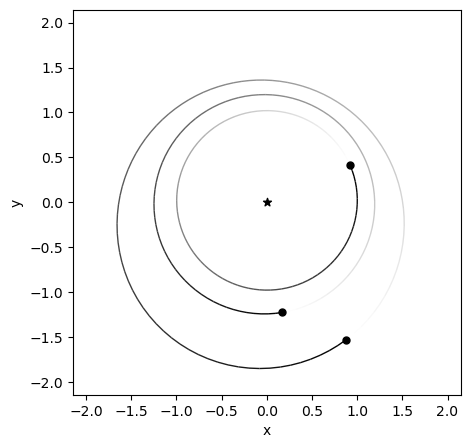

In [37]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()
fig = rebound.OrbitPlot(sim)

# Resonant

In [56]:
7*3600/0.5

50400.0

In [68]:
%%time
import time
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
#tmax = sa[1].t
sim = sa[0]
#sim.dt*=2

CPU times: user 4.26 ms, sys: 0 ns, total: 4.26 ms
Wall time: 2.43 ms


In [69]:
a = np.array([1,2,3])
np.save("/home/yba/test/test.npy", a)
b = np.load("/home/yba/test/test.npy")
a == b

array([ True,  True,  True])

In [71]:
from spock import FeatureClassifier

ModuleNotFoundError: No module named 'spock'

In [70]:
model = FeatureClassifier()
model.predict(sim)

NameError: name 'FeatureClassifier' is not defined

In [75]:
from spock.simsetup import set_sim_parameters, set_timestep
sim.init_megno(seed=0)
sim.integrator_synchronize()
#sim.ri_whfast.keep_unsynchronized = 0
#sim.ri_whfast.safe_mode = 1
#set_sim_parameters(sim)
set_timestep(sim, 0.05)
model.predict(sim, manual=True)

ModuleNotFoundError: No module named 'spock'

In [ ]:
fig = rebound.OrbitPlot(sim)

In [19]:
sim = sa[-1]
sim.t

22660.663202314823

In [16]:
sa[-1].t

10000.000000000007

In [17]:
len(sa)

2

In [4]:
from spock import FeatureClassifier

model = FeatureClassifier()

In [8]:
%%time
model.predict(sim, copy=False)

CPU times: user 1.09 s, sys: 18.1 ms, total: 1.11 s
Wall time: 944 ms


0.9789295792579651

In [9]:
1500/60

25.0

In [28]:
sim2 = sa[1]
sim2.t

206440676.91538927

In [15]:
sim.integrate(1e6)

In [16]:
sim.integrator

'whfast'

In [27]:
sim.G

39.47841760435743

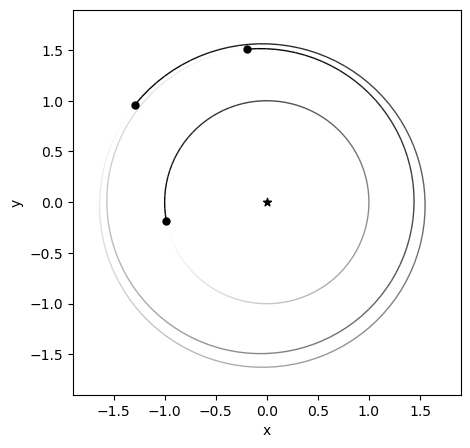

In [23]:
%matplotlib inline
fig = rebound.OrbitPlot(sim)

In [ ]:
# rebound binaries


# Ari

In [5]:
sa = rebound.SimulationArchive(datafolder+'nonressystems/Kepler-431/simulation_archives/runs/sa0000000.bin')

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


# The innermost planet now has a different orbital period, but the timestep is still the same fraction to close to machine precision:

In [6]:
sim = sa[0]
sim.dt/sim.particles[1].P

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


0.03464101615137755

In [9]:
%%time
tmax = sa[1].t
sim = sa[0]
times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	May 30 2019 11:47:14
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	5.2867929037495232e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=-9.243438619388608e-06 y=-5.843309887933348e-06 z=-5.364867056784226e-09 vx=0.00025812578933250956 vy=-0.0004070578950174552 vz=3.717095432586538e-07>
<rebound.Particle object, m=6.606794029325489e-06 x=0.029415138260382036 y=-0.011719099624968315 z=-2.0293887473444915e-05 vx=1.555005645878225 vy=3.789031687122423 vz=-0.000406892740939987>
<rebound.Particle object, m=2.110761752620521e-05 x=0.018112352912284243 y=0.04141347641253959 z=2.7088584243370827e-05 vx=-3.0000505678412064 vy=1.485960978933363 vz=-0.004054656657424565>
<rebound.Particle object, m=6.33670720508826e-05 x=0.0652942480233223 y=0.034455969465934946 z=3.627095560720546e-05 vx=-1.2402945581572582 vy=2.3861143277678045 vz=

In [8]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()

---------------------------------
REBOUND version:     	3.8.2
REBOUND built on:    	May  7 2019 13:37:40
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	5.2867929037495232e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=-9.243438619388608e-06 y=-5.843309887933348e-06 z=-5.364867056784226e-09 vx=0.00025812578933250956 vy=-0.0004070578950174552 vz=3.717095432586538e-07>
<rebound.Particle object, m=6.606794029325489e-06 x=0.029415138260382036 y=-0.011719099624968315 z=-2.0293887473444915e-05 vx=1.555005645878225 vy=3.789031687122423 vz=-0.000406892740939987>
<rebound.Particle object, m=2.110761752620521e-05 x=0.018112352912284243 y=0.04141347641253959 z=2.7088584243370827e-05 vx=-3.0000505678412064 vy=1.485960978933363 vz=-0.004054656657424565>
<rebound.Particle object, m=6.33670720508826e-05 x=0.0652942480233223 y=0.034455969465934946 z=3.627095560720546e-05 vx=-1.2402945581572582 vy=2.3861143277678045 vz=

# Test to show that even though I'm not reproducible when using newest REBOUND on old (random) integrations, I can still load the binary and get the latest time and masses, so I can always use same commit for generate_data/generate_metadata.py


In [10]:
sim = rebound.Simulation(datafolder+'random/final_conditions/runs/fc0000000.bin')
sim.t

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


12356442.121674882

In [12]:
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000000.bin')
sim = sa[0]

In [13]:
sim.particles[1].m

3.4140160192072926e-05

# To get same outputs when stopping at different points with MEGNO, need to pass seed to init_megno, and need to use exact_finish_time=0

In [27]:
%%time
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
sim = sa[0]
sim.ri_whfast.keep_unsynchronized = 1
sim.init_megno(seed=0)
    
times = np.linspace(0, 1e4, 1000)
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    
#sim.integrate(1e4, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jul 26 2019 10:18:51
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000029978431428e+04
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=1.5754637080804735e-05 y=5.552715431442515e-06 z=-1.1669878145708697e-08 vx=-7.301349514488498e-06 vy=4.705456663283622e-05 vz=-1.0008721700251636e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=0.18820747244699707 y=0.9983892059722129 z=-0.006260219550608885 vx=-6.069045419128382 vy=1.1841416303639263 vz=-0.03798729681251473>
<rebound.Particle object, m=1.2444171101394952e-05 x=-1.3363731009885487 y=-0.7954836546826433 z=0.0021957760487688422 vx=2.628852215552226 vy=-4.19628486689365 vz=0.023007745192562795>
<rebound.Particle object, m=2.531702420746453e-07 x=0.4956723760588331 y=1.4533313436553013 z=0.036701363708389 vx=-4.850118344763209 vy=1.7624426656878491 vz=